In [2]:
!pip install graphlearning
import numpy as np
from numpy.linalg import norm
from numpy.random import rand
import matplotlib.pyplot as plt
import graphlearning as gl
import sklearn.datasets as datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 840.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for graphlearning: filename=graphlearning-1.2.1-cp38-cp38-linux_x86_64.whl size=143758 sha256=494cc706299d4883f00512acc9f4e6c8868cbb6e36068ad5a5498f1650c23298
  Stored in directory: /root/.cache/pip/wheels/5e/84/62/681cf2c2a59f1f5e58d52fb110e2eb4c93c9c808d932829543
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=ee7c7b6bd9e5ab98a6f54cc99d44f54d397df4249c4b4af16a20b6e0b7e82966
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built graphlearning sklearn


In [5]:
def graph_grad(u):
    gradu = W[:, :, np.newaxis] * (-u[:, np.newaxis] + u)

    return gradu

def graph_div(V):
    n = V.shape[0]
    k = V.shape[2]
    div = ( V * (W[:, :, np.newaxis] + np.zeros((n,n,k))) ).sum(axis = 1)
    return div

def fast_proxF(V):
    norms = norm(V, axis = 2)

    Z = np.copy(V)
    Z[norms <= sigma] = 0
    Z[norms > sigma] = ((norms[norms > sigma] - sigma)/norms[norms > sigma])[:, np.newaxis] * Z[norms > sigma]
    
    return Z

def proxF(V):
    Z = np.zeros(V.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V_norm = np.linalg.norm(V[i,j])
            if V_norm > sigma:
                Z[i,j] = ( (V_norm - sigma) / V_norm ) * V[i,j]


    return Z

def proxG(u):
    return tau * mu + u

def pd_alg(K, Kstar, proxF, proxG, u0, V0, theta = 1):
    threshold = 0.0001
    difference = threshold+1

    u = u0
    u_bar = np.copy(u0)
    V = V0

    while difference > threshold:
        VV = proxF(V + sigma * K(u_bar))
        uu = proxG(u - tau * Kstar(VV))
        uu_bar = uu + theta * (uu - u)

        difference = np.linalg.norm(uu - u)
        V = VV
        u = uu
        u_bar = uu_bar
        

    return u


def construct_data(n, k = 2, labels_per_class=5):
    # Generate training data and label sets
    X,labels = datasets.make_moons(n_samples=n,noise=0.1, random_state = 0)
    W = gl.weightmatrix.knn(X,10).toarray()

    labeled_ind = gl.trainsets.generate(labels, rate=labels_per_class, seed = 0)
    train_labels = labels[labeled_ind]
    m = labeled_ind.size

    # Construction of measure mu
    # mu[i] = [0, 0] if i is  not in the labeld dataset
    # mu[i] = [1,0] if i is in the labeled dataset and its label is 1
    # mu[i] = [0,1] if i is in the labeled dataset and its label is 0
    
    mean = (labels_per_class/m) * np.ones(2)

    a_idx = labeled_ind[np.argwhere(labels[labeled_ind] == 1)].flatten()
    b_idx = labeled_ind[np.argwhere(labels[labeled_ind] == 0)].flatten()
    mu = np.zeros((n,k))
    mu[a_idx] = [1,0] - mean
    mu[b_idx] = [0,1] - mean

    return X, labels, labeled_ind, W, mu

def predict(u):
    return np.argmax(u, axis = -1)

def power_iteration(K, x_0, termination_threshold = 1e-4, num_iterations = 10000000):
    b = x_0/norm(x_0)
    for _ in range(num_iterations):
        bb = K(b)/norm(K(b))

        if norm(b - bb) < termination_threshold:
            return bb, norm(K(bb))/norm(bb)
        b = bb

    return bb, norm(K_starK(u))/norm(u)

def Kstar_K(u):
    return 2 * np.matmul((np.diag(W.sum(axis = 0)) - W), u)

n = 100
k = 2
X, labels, labeled_ind, W, mu = construct_data(n)

_, eig = power_iteration(Kstar_K, rand(n))
K_norm = np.sqrt(eig)

sigma = 1/ (2* K_norm)
tau = 1/(2 * K_norm )


Accuracy:  0.0


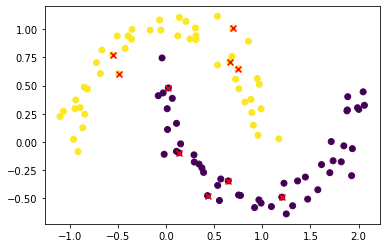

In [6]:
u = pd_alg(graph_grad, lambda x: -graph_div(x), proxF, proxG, np.zeros((n,k)), np.zeros((n, n, k))) 
#print(u)

predictions = predict(u)
print("Accuracy: ", gl.ssl.ssl_accuracy(predictions, labels, len(labeled_ind)))
plt.scatter(X[:,0],X[:,1], c=predictions)
plt.scatter(X[labeled_ind, 0], X[labeled_ind, 1], marker = 'x', c = 'red')